### Objectif: IA Generative Sans API

#### Créer un assistant capable de :

    Comprendre et répondre à des questions sur une image (ex. "Qu'est-ce que cette photo montre ?").
    Générer des images à partir de descriptions textuelles (ex. "Dessine un chat jouant sur la lune").
    Dialoguer en langage naturel pour fournir des réponses textuelles ou multimodales.

#### Architecture du Chatbot Multimodal

    Module Vision :
        Identifier et comprendre le contenu visuel d’une image.
        Utiliser un modèle comme CLIP ou BLIP pour le traitement des images.

    Module Langage :
        Gérer les dialogues et répondre aux requêtes.
        Utiliser un LLM comme GPT.

    Module Génération d’Images :
        Créer des images basées sur les descriptions.
        Modèles recommandés : Stable Diffusion ou DALL·E.

    Intégration :
        Fusionner ces modules pour créer une interface utilisateur (UI), par exemple dans une application web avec Gradio ou Streamlit.

#### Étapes de mise en œuvre
1. Installer les dépendances

Vous aurez besoin des bibliothèques suivantes :

    Hugging Face Transformers : Pour les modèles de vision et de langage.
    diffusers : Pour la génération d'images.
    Gradio : Pour créer une interface utilisateur simple.

In [14]:
#pip install transformers diffusers gradio torch pillow

In [1]:
from transformers import BlipProcessor, BlipForConditionalGeneration, AutoModelForCausalLM, AutoTokenizer
from diffusers import StableDiffusionPipeline
import gradio as gr
from PIL import Image
import torch

In [2]:
# Vérification de l'appareil (CPU ou GPU)
device = "cuda" if torch.cuda.is_available() else "cpu" #si vous avez un pc GPU ou CPU

### Intégrer les fonctionnalités

Crée une interface utilisateur pour interagir avec ces modules.

In [3]:
#pip install huggingface_hub

### Utiliser un modèle valide pour le français

Il y a plusieurs modèles disponibles sur Hugging Face qui fonctionnent bien pour le français. Par exemple :

    Flan-T5 (multilingue)
    GPT-J-6B (multi-langues)
    Bloom (spécifiquement entraîné pour le français et d'autres langues)

In [8]:
#from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

#### On va charger les differents models: pour l'interpretation d'image et la génération d'imgae, text

In [9]:
# Charger les modèles
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Utiliser un modèle local pour la génération de texte (GPT-Neo pour de meilleures performances)
#text_generator_model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M").to(device)
#tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")


#Pour francais
#text_generator_model = AutoModelForCausalLM.from_pretrained("camenduru/french-gpt-j").to(device)
#tokenizer = AutoTokenizer.from_pretrained("camenduru/french-gpt-j")

#model_name = "bigscience/bloom-560m"
#text_generator_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
#tokenizer = AutoTokenizer.from_pretrained(model_name)


# Charger le modèle Flan-T5
model_name = "google/flan-t5-small"
text_generator_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Charger Stable Diffusion pour la génération d'images
stable_diffusion = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)




# Fonction : légender une image
def caption_image(image):#en general: processor, generate, decode
    try:
        inputs = blip_processor(images=image, return_tensors="pt").to(device)
        output = blip_model.generate(**inputs)
        return blip_processor.decode(output[0], skip_special_tokens=True)
    except Exception as e:
        return f"Erreur lors de la légende de l'image : {e}"

# Fonction : générer du texte
def generate_text(prompt):
    try:
        prompt = f"Répondez de manière claire et concise à la question suivante : {prompt}"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = text_generator_model.generate(inputs.input_ids, max_length=100, num_return_sequences=1, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)
    except Exception as e:
        return f"Erreur lors de la génération de texte : {e}"

# Fonction : générer une image
def create_image(prompt):
    try: #pour gerer les erreur
        image = stable_diffusion(prompt).images[0]
        return image
    except Exception as e:
        return f"Erreur lors de la génération de l'image : {e}"


model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Interface utilisateur Gradio

Ici on va creer notre interface User, où on peut interagir avec notre IA. On le fera avec Gradio. vous ouvez aussi le faire avec Streamlit

In [10]:
# Interface utilisateur Gradio
with gr.Blocks() as demo:
    gr.Markdown("# Chatbot Multimodal Sans API : Interprétation et Création")

    with gr.Row():
        with gr.Column():
            user_input = gr.Textbox(label="Texte ou question", placeholder="Décris une image ou pose une question...")
            image_input = gr.Image(label="Image (optionnel)", type="pil")
            submit_button = gr.Button("Soumettre")
        with gr.Column():
            text_output = gr.Textbox(label="Réponse")
            image_output = gr.Image(label="Image générée (si applicable)")

    # Fonction associée au bouton
    def process_input(user_input, image_input):
        if user_input.lower().startswith(("dessine", "crée", "génère")):
            generated_image = create_image(user_input)
            return "", generated_image
        elif image_input is not None:
            caption = caption_image(image_input)
            response = f"Cette image montre : {caption}"
            return response, None
        else:
            response = generate_text(user_input)
            return response, None

    submit_button.click(process_input, inputs=[user_input, image_input], outputs=[text_output, image_output])

In [13]:
# Lancer l'application
demo.launch()

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

C:\Users\efiom\anaconda3\envs\my_IAenv\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\efiom\.cache\huggingface\hub\models--EleutherAI--gpt-neo-125M. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


In [15]:
#pip install matplotlib

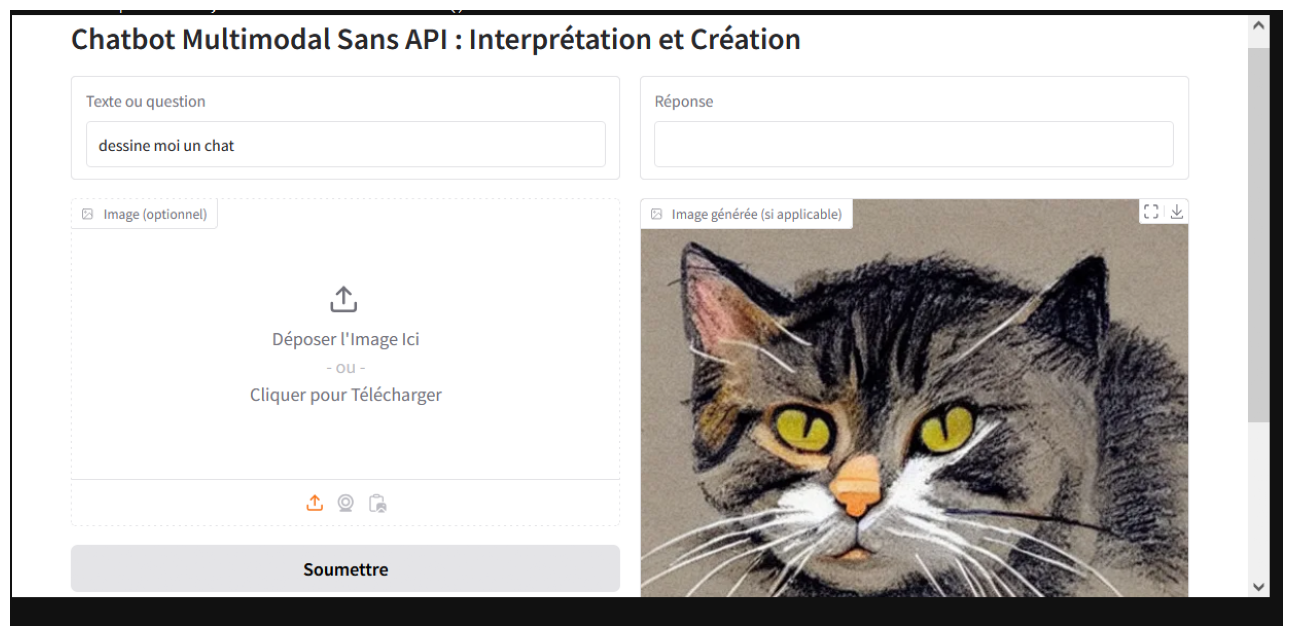

In [26]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


plt.figure(figsize=(18, 8))

image_path2 = 'C:/Users/efiom/Desktop/capt/chat1.png'
#l'image chargée 
img2 = mpimg.imread(image_path2)
# Affichez l'image
plt.imshow(img2)
plt.axis('off') # Pour ne pas afficher les axes
plt.show()

In [12]:
# Lancer l'application
demo.launch(share=True)#share=True pour rendre public. sans cela ca va s'executer mais en local

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://93f3c6f9eba6ccd6e1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


C:\Users\efiom\anaconda3\envs\my_IAenv\lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
C:\Users\efiom\anaconda3\envs\my_IAenv\lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
C:\Users\efiom\anaconda3\envs\my_IAenv\lib\site-packages\transformers\generation\utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
C:\Users\efiom\anaconda3\envs\my_IAenv\lib\site-packages\transformers\generation\utils.py:1375: UserWar

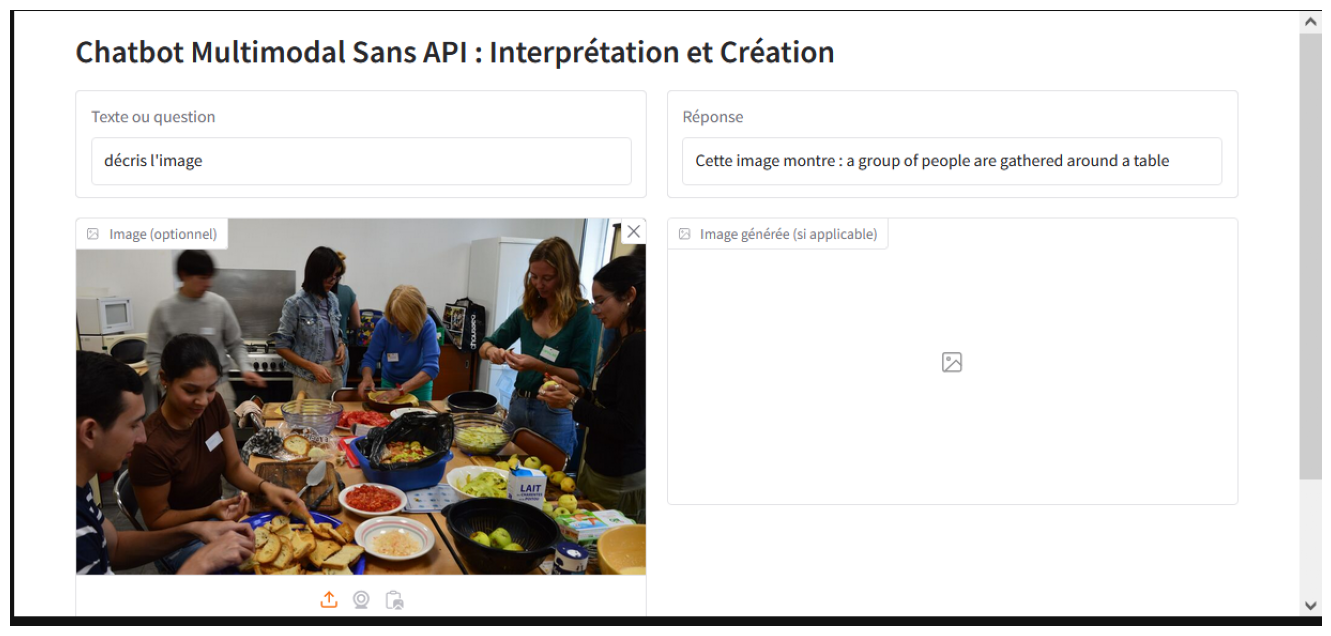

In [25]:
plt.figure(figsize=(18, 8))

image_path2 = 'C:/Users/efiom/Desktop/capt/chat2.png'
#l'image chargée 
img2 = mpimg.imread(image_path2)
# Affichez l'image
plt.imshow(img2)
plt.axis('off') # Pour ne pas afficher les axes
plt.show()

## Points clés de cette version :

 ####   Légende d'image :
 ####   Utilise BLIP pour analyser et interpréter les images localement.

        
 ####  Génération de texte :
 ####  Utilise un modèle GPT-Neo local pour générer des réponses basées sur un prompt texte.

        
 #### Génération d'images :
 #### Utilise Stable Diffusion, qui fonctionne localement pour créer des images basées sur un texte descriptif.

        
 #### Interface conviviale :
 #### Via Gradio, tu peux fournir un texte ou une image et obtenir des résultats immédiats.